# 1. 加载数据

In [1]:
#-*- coding:utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

train_df = pd.read_csv('../data/mtk.parse.subsample.train.csv')
test_df = pd.read_csv('../data/mtk.parse.subsample.test.csv')

excluded_features = ['JobId', 'submitTime']
training_features = ['ArrayIdx', 'userId', 'userGroup', 'queue', 'app', 
                     'project', 'command', 'cwd', 'resReq', 'slots', 'sla', 'subhost', 'infile', 
                     'outfile', 'errfile', 'inFileSpool', 'cmdSpool', 'btime', 'termtime', 'jobname', 'preexec', 
                     'maxslots', 'logshell', 'rsvId', 'lproject', 'postexec', 'jgroup', 'jobDesc', 
                     'outdir', 'subcwd', 'options']
tgt = 'maxmem'

train_X = train_data_df[training_features].values
train_Y = np.log2(train_data_df[tgt].values+1.)

test_X = test_data_df[training_features].values
test_Y = np.log2(test_data_df[tgt]+1.)

#目标函数
def myobj(preds, dtrain):
    a = 0.1
    b = 10
    labels = dtrain.get_label()
    grad = preds - labels
    index1 = grad>=0
    index2 = grad<0
    grad[index1] = a*grad[index1]
    grad[index2] = b*grad[index2]  
    hess = grad.copy()
    hess[index1] = a
    hess[index2] = b
    return grad, hess 

print('Data summary: Train ','(%d, %d)'%(train_X.shape[0], train_X.shape[1]), 
      'Test ','(%d, %d)'%(test_X.shape[0], test_X.shape[1]))

dtrain = xgb.DMatrix(train_X, train_Y,feature_names= training_features)
dval = xgb.DMatrix(test_X, test_Y,feature_names= training_features)

hyper_params = {'eta':[ 0.01],
               'max_depth':[3], 'subsample':[0.01]}

params_grid = ParameterGrid(hyper_params)

for param in params_grid:
    #Step 2 训练模型
    xgb_params = { 
        'eta': param['eta'],
        'max_depth': param['max_depth'],
        'subsample': param['subsample'],
        #  回归任务常使用 reg:linear
        #  分类任务常使用 binary:logistic／multi:softmax
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'base_score': np.median(train_Y),
        'silent': 0
    }
    # 保存boosting每个Iteration的eval result
    evals_result = {}
    num_boost_round = 20000
    model = xgb.train(xgb_params, dtrain, obj=myobj, verbose_eval= 1, num_boost_round=num_boost_round, evals = [(dtrain, "Train"), (dval, "Validation")], 
                      evals_result=evals_result)

    pickle.dump(evals_result, open('subsample/evals_result_xgb_eta_%f_maxdepth_%d_subsample_%f.pkl'%(xgb_params['eta'],
                                                                                          xgb_params['max_depth'],
                                                                                          xgb_params['subsample']),'w'))

    result = evals_result['Validation']['rmse']
    best_niters = np.argmin(result)
    y_pred = model.predict(dval, ntree_limit=best_niters)
    
    pickle.dump({'pred':y_pred, 'label':test_Y}, 'result')
    model.dump_model('subsample/model_eta_%f_maxdepth_%d_subsample_%f.bin'%(xgb_params['eta'],
                                                                  xgb_params['max_depth'],
                                                                  xgb_params['subsample'])
                     ,'subsample/featmap_eta_%f_maxdepth_%d_subsample_%f.bin'%(xgb_params['eta'],
                                                                  xgb_params['max_depth'],
                                                                  xgb_params['subsample']))

# 2. Performance分析

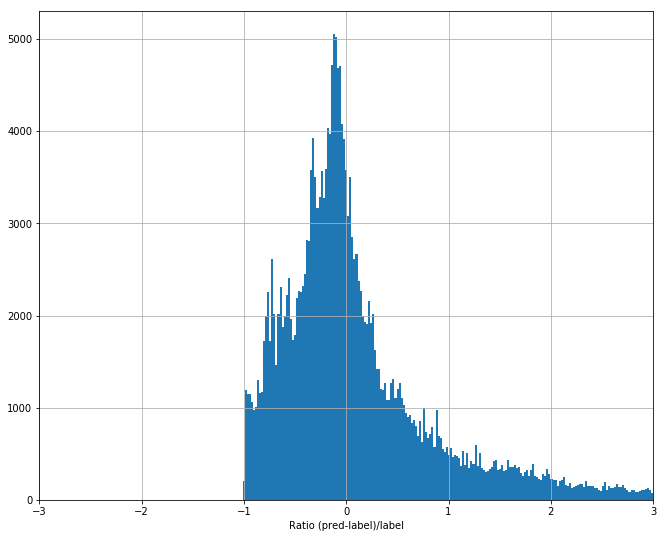

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

result = pickle.load(open('subsample/result.pkl'))

plt.figure(figsize=(11,9))
label = 2**result['label']
pred = 2**result['pred']
# print(label)
# print(pred)
# print(relative[:200])
relative =(pred-label)/label
plt.xlim([-3, 3])
plt.hist(relative, bins=np.linspace(-3,3,300))
plt.grid()
plt.xlabel('Ratio (pred-label)/label')
plt.show()

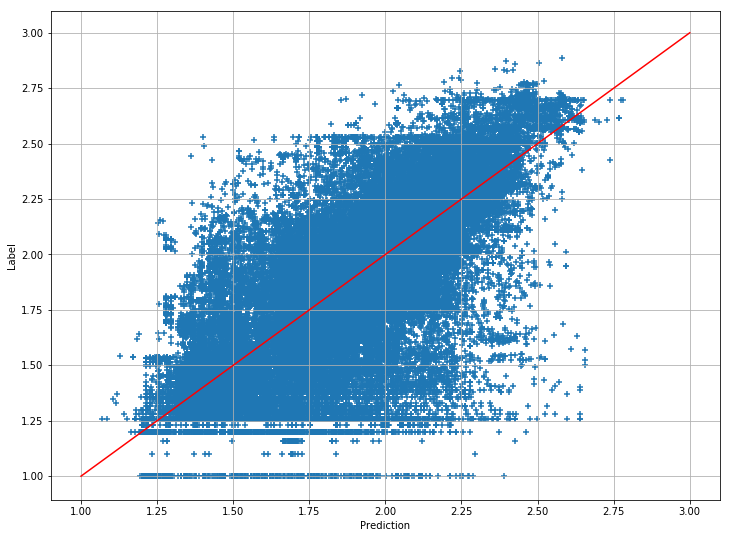

In [50]:
import  numpy as np
plt.figure(figsize=(12,9))
plt.scatter(np.log2(pred)/10., np.log2(label)/10., s=40, marker='+', linewidths=1)
plt.plot([1,3],[1,3],c='r')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.grid()
plt.show()

# 3. 变量重要性

In [ ]:
model = xgb.train(xgb_params, dtrain, verbose_eval= True, num_boost_round=1000)

score_weight = model.get_score(importance_type='weight')
score_gain = model.get_score(importance_type='gain')
score_cover = model.get_score(importance_type='cover')